In [24]:
import pandas as pd

df = pd.read_csv("household_power_consumption.txt", sep=";")

df.index = pd.to_datetime(df["Date"] + " " + df["Time"], dayfirst=True)
df = df.drop(columns=["Date","Time"]).apply(pd.to_numeric, errors="coerce")

hourly = df.resample("h").mean().dropna()
hourly["hour"], hourly["dayofweek"], hourly["month"] = (
    hourly.index.hour, hourly.index.dayofweek, hourly.index.month
)

hourly.shape



/var/folders/q4/1rtzd1ps0wv17j3b84x_d4sc0000gn/T/ipykernel_35239/90391097.py:3: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("household_power_consumption.txt", sep=";")


(34168, 10)

In [6]:
hourly.to_csv("hourly.csv")



In [7]:
split = int(len(hourly) * 0.8)

train = hourly.iloc[:split]
test = hourly.iloc[split:]

y_train = train["Global_active_power"]
y_test = test["Global_active_power"]

len(train), len(test), y_train.index.max(), y_test.index.min()


(27334,
 6834,
 Timestamp('2010-02-05 04:00:00'),
 Timestamp('2010-02-05 05:00:00'))

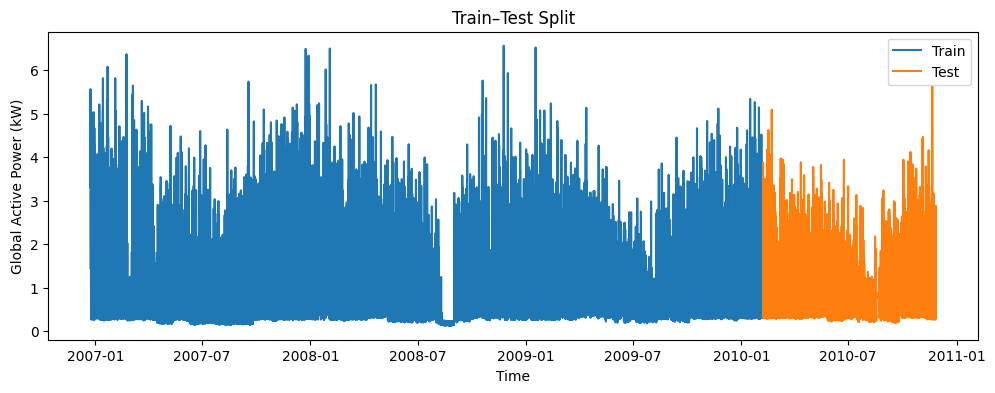

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Test")
plt.title("Train–Test Split")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.show()


In [9]:
import sys
!{sys.executable} -m pip install statsmodels




[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [10]:
from statsmodels.tsa.arima.model import ARIMA


In [11]:
arima = ARIMA(y_train, order=(5,1,0)).fit()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
arima_pred = arima.forecast(steps=len(y_test))
arima_pred.index = y_test.index
arima_pred.head()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


2010-02-05 05:00:00    0.555530
2010-02-05 06:00:00    0.701095
2010-02-05 07:00:00    0.802584
2010-02-05 08:00:00    0.816537
2010-02-05 09:00:00    0.761863
Name: predicted_mean, dtype: float64

In [13]:
import sys
!{sys.executable} -m pip install scikit-learn




[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [15]:
import numpy as np


In [16]:
arima_mae = mean_absolute_error(y_test, arima_pred)
arima_rmse = np.sqrt(mean_squared_error(y_test, arima_pred))

arima_mae, arima_rmse


(0.5969885181445344, np.float64(0.7998945336093692))

In [ ]:
rf_data = hourly.copy()

In [26]:

for lag in [1, 24, 168]:
    rf_data[f"lag_{lag}"] = rf_data["Global_active_power"].shift(lag)

rf_data = rf_data.dropna()
rf_data.shape



(33664, 13)

In [18]:
split = int(len(rf_data) * 0.8)

train_rf = rf_data.iloc[:split]
test_rf = rf_data.iloc[split:]

X_train = train_rf[["hour", "dayofweek", "month", "lag_1", "lag_24", "lag_168"]]
y_train = train_rf["Global_active_power"]

X_test = test_rf[["hour", "dayofweek", "month", "lag_1", "lag_24", "lag_168"]]
y_test = test_rf["Global_active_power"]

X_train.shape, X_test.shape


((27200, 6), (6800, 6))

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=300,random_state=42,n_jobs=-1
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [20]:
rf_pred = pd.Series(rf.predict(X_test), index=y_test.index)
rf_pred.head()


2010-02-06 15:00:00    1.953902
2010-02-06 16:00:00    2.416336
2010-02-06 17:00:00    2.849540
2010-02-06 18:00:00    2.795833
2010-02-06 19:00:00    3.797813
dtype: float64

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

rf_mae, rf_rmse


(0.3468179461097582, np.float64(0.4970779932945055))

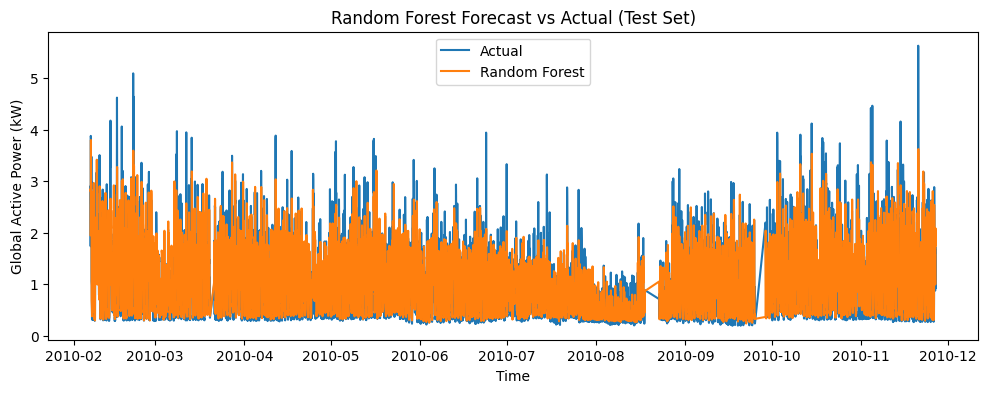

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(rf_pred.index, rf_pred, label="Random Forest")
plt.title("Random Forest Forecast vs Actual (Test Set)")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.show()
